In [6]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


In [7]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

pdf_retriever를 tool로 만들어 agent가 사용할 수 있게 선언

In [8]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 기반으로 검색 도구 생성
retriever_tool = create_retriever_tool(
    pdf_retriever,# 문서 검색기
    "pdf_retriever",# 도구 이름(agent가 호출할 때 쓸 이름)
    # 도구 설명
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    # 검색 결과를 포맷팅하는 템플릿
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

# 생성된 검색 도구를 도구 리스트에 추가하여 에이전트에서 사용 가능하도록 설정
tools = [retriever_tool]

이 코드는 에이전트가 대화 중 주고받은 메시지들을 히스토리 형태로 누적 관리하기 위한 상태 정의입니다.

In [9]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


# 에이전트 상태를 정의하는 타입 딕셔너리, 메시지 시퀀스를 관리하고 추가 동작 정의
class AgentState(TypedDict):
    # add_messages reducer 함수를 사용하여 메시지 시퀀스를 관리
    messages: Annotated[Sequence[BaseMessage], add_messages]

### ✔️ 이 코드는 문서 검색 후 관련성 평가 → 관련성 없으면 질문 재작성 → 관련성 있으면 답변 생성의 RAG 파이프라인을 정의한 예시입니다.
### ✔️ grade_documents는 검색된 문서와 질문을 비교해 “관련 있음/없음”을 판정하고, rewrite는 질문을 개선하며, generate는 최종 답변을 생성합니다.
### ✔️ 전체적으로 에이전트가 tools를 활용해 검색·평가·생성을 오가며 더 정확하고 최적화된 답변을 만들어내는 구조입니다.

In [10]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_teddynote.models import get_model_name, LLMs

yes 혹은 no 값만 나오게하는 class

In [11]:
# 최신 모델이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 데이터 모델 정의
class grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )

검색된 문서가 사용자의 질문과 관련이 있는지 없는지를 판정하는 노드 함수

원래 질문과 현재 가장 마지막으로 나온 문서를 대조하여 관련성을 평가하여 관련성이 있다면 genete, 없다면 rewrite값을 return함.

In [12]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)

    # 구조화된 출력을 위한 LLM 설정
    # with_structured_output 코드로 grade에서 description된 yes 혹은 no 의 output값이 나오게됨.
    llm_with_tool = model.with_structured_output(grade)

    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool

    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 가장 마지막 메시지 추출
    last_message = messages[-1]

    # 원래 질문 추출
    question = messages[0].content

    # 검색된 문서 추출
    retrieved_docs = last_message.content

    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    # 관련성 여부 추출
    score = scored_result.binary_score

    # 관련성 여부에 따른 결정
    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"

    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"

이 함수는 현재까지의 대화와 도구를 바탕으로 LLM이 새로운 응답을 생성하고, 그 결과를 상태(messages)에 추가하는 에이전트 노드입니다.

In [13]:
def agent(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, streaming=True, model=MODEL_NAME)

    # retriever tool 바인딩
    model = model.bind_tools(tools)

    # 에이전트 응답 생성
    response = model.invoke(messages)

    # 기존 리스트에 추가되므로 리스트 형태로 반환
    return {"messages": [response]}

사용자의 첫 질문을 받아서, 의미는 유지하면서 더 명확하고 검색 친화적인 형태로 재작성하는 노드

In [14]:
def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    # 현재 상태에서 메시지 추출
    messages = state["messages"]
    # 원래 질문 추출
    question = messages[0].content

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # LLM 모델로 질문 개선
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    # Query-Transform 체인 실행
    response = model.invoke(msg)

    # 재작성된 질문 반환
    return {"messages": [response]}

teddynote/rag-prompt는 검색된 문맥(context)에 기반해 질문에 간결하고 정확하게 답하고, 반드시 출처를 표시하게 강제하는 RAG용 QA 프롬프트입니다.

RAG 최종 답변 생성 단계를 담당하는 노드

In [15]:
def generate(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 원래 질문 추출
    question = messages[0].content

    # 가장 마지막 메시지 추출
    docs = messages[-1].content

    # RAG 프롬프트 템플릿 가져오기
    prompt = hub.pull("teddynote/rag-prompt")

    # LLM 모델 초기화
    llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0, streaming=True)

    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()

    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

### 그래프 노드 연결

In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# AgentState 기반 상태 그래프 워크플로우 초기화
workflow = StateGraph(AgentState)

# 노드 정의
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node("generate", generate)  # 관련 문서 확인 후 응답 생성 노드

# 엣지 연결
workflow.add_edge(START, "agent")

# 검색 여부 결정을 위한 조건부 엣지 추가
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 노드에 매핑
        "tools": "retrieve",
        END: END,
    },
)

# 액션 노드 실행 후 처리될 엣지 정의
workflow.add_conditional_edges(
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

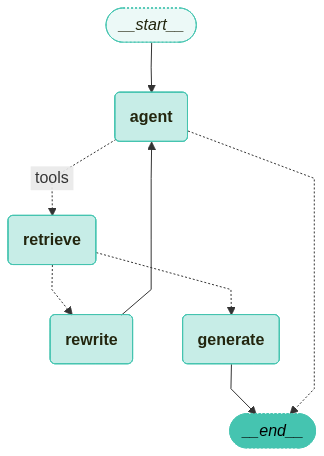

In [17]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

### 그래프 실행

In [18]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_gANWeLhzJuJAVwgzAp1VMxYg)
 Call ID: call_gANWeLhzJuJAVwgzAp1VMxYg
  Args:
    query: 삼성전자 생성형 AI 이름
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어,

In [19]:
# 그래프 스트리밍 출력
# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자 생성 AI"),
    ]
}
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)

In [20]:
# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}

# 그래프 실행
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울입니다.

In [22]:
from langgraph.errors import GraphRecursionError

# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "테디노트의 랭체인 튜토리얼에 대해서 알려줘"),
    ]
}

try:
    # 그래프 실행
    stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS NOT RELEVANT] ====
no
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What is the name of the generative AI developed by Samsung Electronics?
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
테디노트의 랭체인 튜토리얼에 대한 구체적인 정보는 제공되지 않았습니다. 현재로서는 관련된 내용을 찾을 수 없습니다. 추가적인 정보나 다른 질문이 있으시면 말씀해 주세요!